In [68]:
import requests
import json
import time
from datetime import datetime
import pandas as pd
import numpy as np
from numpy import savetxt
from numpy import asarray
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join
import numpy.random as rng

In [69]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv1D,Conv2D, ZeroPadding2D, Activation, Input, concatenate,MaxPooling1D
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K


In [70]:
def slitDataSetWithSize(dataset,size):
    dataLen = dataset.shape[0]
    lsRs = []
    for e in range(0,(dataLen//size)):
        lsRs.append(dataset[e*size:(e+1)*size].to_numpy())
    if (dataLen % size > 0):
        lsRs.append(dataset[(dataLen-size):(dataLen)].to_numpy())
    return np.array(lsRs)
def slipDataAndLabel(rs1,slitIndex):

    labelaf = rs1[:,:,(slitIndex):(slitIndex+1)]
    dataaf = np.delete(rs1, np.s_[(slitIndex):(slitIndex+1)], 2)

    return (dataaf,labelaf[:,1].reshape(dataaf.shape[0]))

# a = pd.DataFrame([[1,1,3],[4,1,6],[7,0,9],[10,0,12],[13,1,15],[16,1,18],[19,1,21]])
# rs1 = slitDataSetWithSize(a,2)
# (datat,datal) = slipDataAndLabel(rs1,1)
# print(datat)
# print(datal)

In [71]:
def viewAllDataFromFolder(dataPath):
    onlyfiles = [f for f in listdir(dataPath) if isfile(join(dataPath, f))]
    count = 0
    fileLs = []
    lsBdTrain = None
    dataList = []
    for fs in onlyfiles:
        count = count + 1
        dataItem = pd.read_pickle(dataPath+"/"+fs)
        dataItem["FileIndex"]=count
        dataList.append(dataItem)
    frame = pd.concat(dataList)
    frame = frame.reset_index().fillna(0)
    frame["node"] = frame["node"].apply(lambda x : 2 if x=="tan-k2" else 3 if x=="tan-k3" else 1 if x=="tan-km" else x)
    return (frame,count)

def slitDataSetToNP(frame,count,size):
#     print(frame.shape)
#     print(count)
#     print(len(onlyfiles))
    lsNP = np.array([])
    for cc in range(1,count+1):
        dfn = frame[frame['FileIndex']==cc]
        datasort = dfn.sort_values(by=['timestamp'])
        rsNP = slitDataSetWithSize(datasort,size)
        if lsNP.size==0 :
            lsNP = rsNP
        else :
            lsNP = np.append(lsNP, rsNP, axis=0)
#         print(rsNp.shape)
    return lsNP

def normalizeColumn(datas,fromCol,toCol):
    cols = datas.columns
    for e in range(fromCol,toCol):
        normalized_df=(datas[cols[e]]-datas[cols[e]].mean())/datas[cols[e]].std()
        datas[cols[e]] = normalized_df
    return datas

In [72]:
(dataset,filecount) = viewAllDataFromFolder("CBT/data")

In [73]:
dataset.head()

,timestamp,cpu_system,cpu_idle,cpu_user,cpu_iowait,pod_count,system_load,mem_total,mem_avail,disk_io,disk_space_used,net_received,net_transmit,node,label,FileIndex
0,1.625210e+09,0.055000,0.758333,0.171000,0.001000,9.0,0.70,2.641199e+09,1.444844e+09,0.006933,0.590030,605856.533333,8.034681e+06,2,1,1
1,1.625210e+09,0.055000,0.758333,0.171000,0.001000,9.0,0.70,2.641199e+09,1.444844e+09,0.006933,0.590030,605856.533333,8.034681e+06,2,1,1
2,1.625210e+09,0.046333,0.813333,0.115333,0.000667,9.0,0.71,2.678424e+09,1.407619e+09,0.001867,0.590039,893741.333333,8.794958e+06,2,1,1
3,1.625210e+09,0.046333,0.813333,0.115333,0.000667,9.0,0.71,2.678424e+09,1.407619e+09,0.001867,0.590039,893741.333333,8.794958e+06,2,1,1
4,1.625210e+09,0.046333,0.813333,0.115333,0.000667,9.0,0.71,2.678424e+09,1.407619e+09,0.001867,0.590039,893741.333333,8.794958e+06,2,1,1


In [74]:
datasetnorm = normalizeColumn(dataset,1,12)

In [75]:
datanp = slitDataSetToNP(datasetnorm,filecount,121)
datanp = np.delete(datanp, np.s_[(0):(1)], 2)#Remove timestamp
datanp = np.delete(datanp, np.s_[(12):(13)], 2)#Remove node
datanp = np.delete(datanp, np.s_[(13):(14)], 2)#Remove file index

In [76]:
datanp

array([[[-8.67326925e-01,  1.54682859e+00, -8.08608325e-01, ...,
         -4.67563376e-01,  8.03468107e+06,  1.00000000e+00],
        [-8.67326925e-01,  1.54682859e+00, -8.08608325e-01, ...,
         -4.67563376e-01,  8.03468107e+06,  1.00000000e+00],
        [-9.19028615e-01,  1.72955666e+00, -9.99652344e-01, ...,
         -4.44000022e-01,  8.79495787e+06,  1.00000000e+00],
        ...,
        [-8.43464606e-01,  1.62767192e+00, -9.67621011e-01, ...,
         -4.49073060e-01,  9.74221333e+06,  1.00000000e+00],
        [-7.95739969e-01,  1.48481178e+00, -8.22336039e-01, ...,
         -4.72156358e-01,  1.00563984e+07,  1.00000000e+00],
        [-7.95739969e-01,  1.48481178e+00, -8.22336039e-01, ...,
         -4.72156358e-01,  1.00563984e+07,  1.00000000e+00]],

       [[-7.95739969e-01,  1.48481178e+00, -8.22336039e-01, ...,
         -4.72156358e-01,  1.00563984e+07,  1.00000000e+00],
        [-8.11648182e-01,  1.48370434e+00, -8.74958942e-01, ...,
         -4.45703941e-01,  1.01058128e

In [77]:
(datatrain,datalabel) = slipDataAndLabel(datanp,12)

In [78]:
datatrain

array([[[-8.67326925e-01,  1.54682859e+00, -8.08608325e-01, ...,
          1.39254028e-01, -4.67563376e-01,  8.03468107e+06],
        [-8.67326925e-01,  1.54682859e+00, -8.08608325e-01, ...,
          1.39254028e-01, -4.67563376e-01,  8.03468107e+06],
        [-9.19028615e-01,  1.72955666e+00, -9.99652344e-01, ...,
          1.39294456e-01, -4.44000022e-01,  8.79495787e+06],
        ...,
        [-8.43464606e-01,  1.62767192e+00, -9.67621011e-01, ...,
          1.40584576e-01, -4.49073060e-01,  9.74221333e+06],
        [-7.95739969e-01,  1.48481178e+00, -8.22336039e-01, ...,
          1.40613113e-01, -4.72156358e-01,  1.00563984e+07],
        [-7.95739969e-01,  1.48481178e+00, -8.22336039e-01, ...,
          1.40613113e-01, -4.72156358e-01,  1.00563984e+07]],

       [[-7.95739969e-01,  1.48481178e+00, -8.22336039e-01, ...,
          1.40613113e-01, -4.72156358e-01,  1.00563984e+07],
        [-8.11648182e-01,  1.48370434e+00, -8.74958942e-01, ...,
          1.40655324e-01, -4.45703941e

In [79]:
datalabel

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [80]:
def generateBatch(xTrain, yTrain, batchSize):
    inputLLs = []
    inputRLs = []
    targetLs = []
    gr0Index = 0
    gr1Index = 1
    classes = np.unique(yTrain)
#     print("classes:",classes)
    chooseDiffClasses = [0,0]
    chooseDiffClasses[0] = rng.choice(classes)
    chooseDiffClasses[1] = rng.choice([i for i in classes if i not in [chooseDiffClasses[0]]])
    
    chooseSameClasses = rng.choice(classes)
    
    numPerChoose = batchSize // 2

#     print("chooseDiffClasses:",chooseDiffClasses)
#     print("chooseSameClasses:",chooseSameClasses)
    
    #For same class
#     print("For same class")
    
    indexSCLs = np.where(yTrain==chooseSameClasses)[0]
    rng.shuffle(indexSCLs)
#     print("indexSCLs:",indexSCLs)
    
    indexSC1 = rng.choice(indexSCLs[0:len(indexSCLs)//2],numPerChoose)
    indexSC2 = rng.choice(indexSCLs[len(indexSCLs)//2:len(indexSCLs)],numPerChoose)
#     print("indexSC1:",indexSC1)
#     print("indexSC2:",indexSC2)
    inputLLs = xTrain[indexSC1]
    inputRLs = xTrain[indexSC2]
    targetLs = np.full((1, numPerChoose), 1)[0]
    
#     print(inputLLs)
#     print(inputRLs)
#     print(targetLs)
    
    #For diff classes
#     print("For diff class")

    indexSC1Ls = np.where(yTrain==chooseDiffClasses[0])[0]
    rng.shuffle(indexSC1Ls)
    indexSC2Ls = np.where(yTrain==chooseDiffClasses[1])[0]
    rng.shuffle(indexSC2Ls)
    
    indexSC1 = rng.choice(indexSC1Ls,numPerChoose)
    indexSC2 = rng.choice(indexSC2Ls,numPerChoose)
    
    inputLLs = np.append(inputLLs, xTrain[indexSC1], axis=0)
    inputRLs = np.append(inputRLs, xTrain[indexSC2], axis=0)
    targetLs = np.append(targetLs,np.full((1, numPerChoose), 0)[0])
#     print(inputLLs)
#     print(inputRLs)
#     print(targetLs)
    
#     for i in choosedClasses:
        
#     for i in range(0, len(yTrain)):
#         for j in range(i+1, len(yTrain)):
#             ck = int(yTrain[i]==yTrain[j])
# #             print(xTrain[i].reshape(8,1))
#             inputLLs.append(xTrain[i].reshape(8,1))
#             inputRLs.append(xTrain[j].reshape(8,1))
# #             print(yTrain[i]," ",yTrain[j]," ",ck)
#             targetLs.append(ck)
    inputLLs = inputLLs.reshape(inputLLs.shape[0],inputLLs.shape[1],inputLLs.shape[2],1)
    inputRLs = inputRLs.reshape(inputRLs.shape[0],inputRLs.shape[1],inputRLs.shape[2],1)

    return ((inputLLs, inputRLs), targetLs)
# 

In [81]:
(inputs,targets) = generateBatch(datatrain,datalabel,4)

In [82]:
inputs[0].shape

(4, 121, 12, 1)

In [83]:
targets

array([1, 1, 0, 0])

In [84]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
#     model = keras.Sequential()
    model.add(keras.layers.TimeDistributed(keras.layers.Conv1D(filters=4, kernel_size=3, activation='relu'), input_shape=input_shape))
    model.add(keras.layers.TimeDistributed(keras.layers.Conv1D(filters=4, kernel_size=3, activation='relu')))
#     model.add(keras.layers.TimeDistributed(keras.layers.Dropout(0.5)))
    model.add(keras.layers.TimeDistributed(keras.layers.MaxPooling1D(pool_size=2)))
    model.add(keras.layers.TimeDistributed(keras.layers.Flatten()))
    model.add(keras.layers.LSTM(70))
#     model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(30, activation='relu'))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [85]:
model = get_siamese_model((121, 12,1))
# optimizer = Adam(lr = 0.0001)
# model.compile(loss="binary_crossentropy",optimizer=optimizer)
# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 121, 12, 1)] 0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 121, 12, 1)] 0                                            
__________________________________________________________________________________________________
sequential_17 (Sequential)      (None, 30)           26558       input_27[0][0]                   
                                                                 input_28[0][0]                   
__________________________________________________________________________________________________
lambda_13 (Lambda)              (None, 30)           0           sequential_17[0][0]  

In [86]:
def compareArr(A,B):
    number_of_equal_elements = np.sum(A==B)
#     print(number_of_equal_elements)
    total_elements = len(A)
    percentage = number_of_equal_elements/total_elements
    return (number_of_equal_elements,total_elements,percentage)

def testOneShotDirect(model,inputs,targets):
    accCount = 0
    total = 0
    testNum = 1
    batchSize = 10
#     for i in range(0,testNum):
#     inputs, targets = generateBatch(datatrain,datalabel,batchSize)
    probs = model.predict(inputs)
#         print(probs.shape)
    probs = probs.reshape(1,len(probs))[0]
#         print(probs)
    for j in range(0,len(probs)):
        if (probs[j] < 0.5):
            probs[j] = 0
        else:
            probs[j] = 1
#     print(targets)
#     print(probs)
    (c,t,p) = compareArr(probs,targets)
#         print(c,t,p)
    accCount = accCount + c
    total = total + t
#     print(accCount,total)
    print("Percent:", (accCount*100)/total)

def testOneShot(model,datatrain,datalabel):
    accCount = 0
    total = 0
    testNum = 10
    batchSize = 10
    for i in range(0,testNum):
        inputs, targets = generateBatch(datatrain,datalabel,batchSize)
        probs = model.predict(inputs)
#         print(probs)
#         print(probs.shape)
        probs = probs.reshape(1,len(probs))[0]
#         print(probs)
        for j in range(0,len(probs)):
            if (probs[j] < 0.5):
                probs[j] = 0
            else:
                probs[j] = 1
#         print(targets)
#         print(probs)
        (c,t,p) = compareArr(probs,targets)
#         print(c,t,p)
        accCount = accCount + c
        total = total + t
#     print(accCount,total)
    return ((accCount*100)/total)

In [87]:
def slitData(datatrain,datalabel,validatePercent):
#     validatePercent = 30
    chooseLsIndex = rng.choice(datatrain.shape[0],int(datatrain.shape[0] * validatePercent / 100))
#     print(chooseLsIndex)
    dataVal = datatrain[chooseLsIndex]
    labelVal = datalabel[chooseLsIndex]
#     print(dataVal.shape)
    indexRest = []
    for e in range(0,datatrain.shape[0]):
        if not e in chooseLsIndex:
            indexRest.append(e)
#     print(indexRest)
    dataTr = datatrain[indexRest]
    labelTr = datalabel[indexRest]
    return (dataTr, labelTr, dataVal, labelVal)

In [88]:
datatrain.shape

(94, 121, 12)

In [89]:
(dataTr, labelTr, dataVal, labelVal) = slitData(datatrain,datalabel,30)

In [90]:
print(dataTr.shape)
print(dataVal.shape)

(69, 121, 12)
(28, 121, 12)


In [169]:
epoch=500
batchSize=20
maxValPer = 0
lossLs = []
accuracyTrainLs = []
accuracyValLs = []

(dataTr, labelTr, dataVal, labelVal) = slitData(datatrain,datalabel,30)

model = get_siamese_model((121, 12,1))
# optimizer = Adam(lr = 0.0001)
# model.compile(loss="binary_crossentropy",optimizer=optimizer)
# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.summary()

In [170]:
# def train():
for i in range(0,epoch):
    (inputs,targets) = generateBatch(dataTr,labelTr,batchSize)
#     (inputs,targets) = generateBatch(XTrain,YTrain,batchSize)
    history = model.train_on_batch(inputs, targets)
#     if i%10 ==0:
    valPer = testOneShot(model, dataVal, labelVal)
    if valPer > maxValPer :
        maxValPer = valPer
        model.save(str(maxValPer)+'_OneShot.h5')
        print("maxValPer:",maxValPer)
    lossLs.append(history[0])
    accuracyTrainLs.append(history[1])    
    accuracyValLs.append(valPer/100)
#     if valPer==100:
#         print("Done 100")
#         break;
    print(history)
    print(valPer)

maxValPer: 40.0
[0.7116158604621887, 0.44999998807907104]
40.0
maxValPer: 45.0
[0.7078332901000977, 0.4000000059604645]
45.0
maxValPer: 48.0
[0.7013430595397949, 0.44999998807907104]
48.0
maxValPer: 51.0
[0.6959624290466309, 0.3499999940395355]
51.0
maxValPer: 53.0
[0.6859889030456543, 0.6499999761581421]
53.0
maxValPer: 55.0
[0.6937440037727356, 0.550000011920929]
55.0
maxValPer: 60.0
[0.6755985021591187, 0.6499999761581421]
60.0
[0.6940431594848633, 0.5]
60.0
maxValPer: 63.0
[0.6642876267433167, 0.699999988079071]
63.0
maxValPer: 65.0
[0.692237913608551, 0.44999998807907104]
65.0
[0.6859928369522095, 0.5]
62.0
[0.6932591199874878, 0.5]
60.0
[0.6797668933868408, 0.5]
59.0
[0.6779309511184692, 0.5]
54.0
[0.6447870135307312, 0.6000000238418579]
59.0
[0.6666526794433594, 0.5]
56.0
[0.6274532079696655, 0.6000000238418579]
53.0
[0.6689068675041199, 0.5]
61.0
[0.6666637659072876, 0.5]
58.0
[0.6512144207954407, 0.550000011920929]
57.0
[0.6179872751235962, 0.6000000238418579]
57.0
[0.60207766

[0.18139764666557312, 1.0]
92.0
[0.125361829996109, 1.0]
94.0
[0.19359447062015533, 1.0]
92.0
[0.1487494260072708, 1.0]
93.0
[0.3253958523273468, 0.949999988079071]
95.0
[0.3767012059688568, 0.949999988079071]
90.0
[0.12561675906181335, 1.0]
92.0
[0.18151792883872986, 1.0]
84.0
[0.17553099989891052, 1.0]
95.0
[0.14173248410224915, 1.0]
94.0
[0.1313697099685669, 1.0]
88.0
[0.16701015830039978, 1.0]
95.0
[0.18388712406158447, 1.0]
93.0
[0.1761815994977951, 1.0]
85.0
[0.16153839230537415, 1.0]
90.0
[0.13812261819839478, 1.0]
93.0
[0.18056073784828186, 1.0]
90.0
[0.2627173066139221, 0.949999988079071]
90.0
[0.1887800693511963, 1.0]
99.0
[0.12429378926753998, 1.0]
100.0
[0.21233348548412323, 1.0]
100.0
[0.15022197365760803, 1.0]
100.0
[0.14844168722629547, 1.0]
100.0
[0.12780897319316864, 1.0]
100.0
[0.15487225353717804, 1.0]
100.0
[0.07910427451133728, 1.0]
100.0
[0.09920841455459595, 1.0]
100.0
[0.1728697270154953, 1.0]
99.0
[0.13576991856098175, 1.0]
99.0
[0.1320824921131134, 1.0]
100.0


[0.08582236617803574, 1.0]
100.0
[0.08232603222131729, 1.0]
100.0
[0.05394315719604492, 1.0]
100.0
[0.09362427145242691, 1.0]
100.0
[0.08429538458585739, 1.0]
100.0
[0.04909361153841019, 1.0]
99.0
[0.071619912981987, 1.0]
100.0
[0.08177642524242401, 1.0]
100.0
[0.05750788375735283, 1.0]
100.0
[0.054743070155382156, 1.0]
100.0
[0.05206378549337387, 1.0]
100.0
[0.05979114770889282, 1.0]
99.0
[0.022592563182115555, 1.0]
99.0
[0.07792781293392181, 1.0]
100.0
[0.0401649996638298, 1.0]
99.0
[0.19319191575050354, 0.949999988079071]
100.0
[0.043440233916044235, 1.0]
100.0
[0.28702232241630554, 0.8999999761581421]
99.0
[0.03295327350497246, 1.0]
100.0
[0.03419818729162216, 1.0]
100.0
[0.03964689001441002, 1.0]
100.0
[0.07569636404514313, 1.0]
100.0
[0.041287850588560104, 1.0]
100.0
[0.050529349595308304, 1.0]
100.0
[0.028818881139159203, 1.0]
100.0
[0.04974215105175972, 1.0]
99.0
[0.0499388612806797, 1.0]
100.0
[0.11535750329494476, 1.0]
100.0
[0.07044222950935364, 1.0]
98.0
[0.0694755539298057

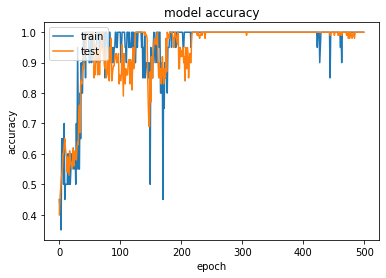

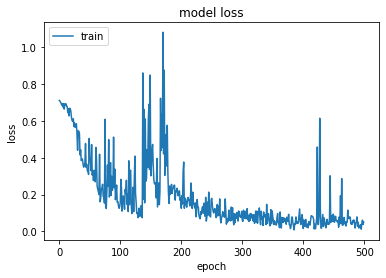

In [171]:
# list all data in history
# summarize history for accuracy
plt.plot(accuracyTrainLs)
plt.plot(accuracyValLs)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(lossLs)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()